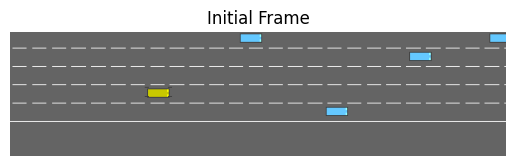

In [1]:
# Import libraries and make sure highway-env is installed properly
import gymnasium
import highway_env
import numpy as np
import matplotlib.pyplot as plt

# Create the environment with visual rendering
env = gymnasium.make("highway-better-v1", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

import torch
import tensorboard

print(tensorboard.__version__)
print(torch.cuda.is_available())   
# print(torch.cuda.get_device_name(0))  # Should show GPU name


Environment Information:
{'action': {'acceleration_range': [-1, 1],
            'lateral': True,
            'longitudinal': True,
            'speed_range': [0, 40],
            'steering_range': [-0.1, 0.1],
            'type': 'ContinuousAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 60,
 'ego_spacing': 1.5,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 5,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'absolute': False,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'heading',
                              'lat_off'],
                 'type': 'Kinematics',
                 'vehicles_count': 40},
 'offroad_terminal': True,
 'offscreen_rendering': False,
 'on_road_reward': 0.5,
 'other_v

In [3]:
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor

# === Create wrapped evaluation env ===
def make_env(str_env=None):
    def _init():
        if str_env is None or str_env == "highway":
            env_id = "highway-better-v1"
        elif str_env == "intersection":
            env_id = "intersection-v1"
        elif str_env == "racetrack":
            env_id = "racetrack-v0"
        else:
            raise ValueError(f"Unknown environment: {str_env}")

        env = gym.make(env_id, render_mode="rgb_array")
        return Monitor(env)
    return _init


In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([make_env("highway")])  
# print the action space
print("Action Space:", env.action_space)

Action Space: Box(-1.0, 1.0, (2,), float32)


In [ ]:
import optuna
import torch
import os
import json
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner
from stable_baselines3.common.vec_env import DummyVecEnv


torch.set_num_threads(1)  # Prevent CPU thread oversubscription
best_rewards = {}

# === Callback for pruning ===
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=500, n_eval_episodes=1, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.last_reward = -float("inf")

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            try:
                self.last_reward, _ = evaluate_policy(
                    self.model,
                    self.training_env,
                    n_eval_episodes=self.n_eval_episodes,
                    deterministic=True
                )
                print(f"📊 Trial {self.trial.number} | Step {self.n_calls} | Reward: {self.last_reward:.2f}")
            except Exception as e:
                print(f"⚠️ Evaluation failed at step {self.n_calls}: {e}")
                self.last_reward = -float("inf")

            self.trial.report(self.last_reward, self.n_calls)
            if self.trial.should_prune():
                print(f"⏹️ Trial {self.trial.number} pruned at step {self.n_calls}")
                raise optuna.exceptions.TrialPruned()
        return True  # ✅ Must return True to continue training


# === Objective Function ===
def objective(trial, phase, str_env, coarse_params=None, save_dir=None):
    global best_rewards
    coarse_params_path = os.path.join(save_dir, "SAC_best_coarse_params.json")

    if str_env not in best_rewards:
        best_rewards[str_env] = {"coarse": -float("inf"), "fine": -float("inf")}

    # === Hyperparameters ===
    if phase == "coarse":
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float("gamma", 0.9, 0.999)
        net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
        learning_starts = trial.suggest_categorical("learning_starts", [1000, 2000])
        config = {
            "learning_rate": learning_rate,
            "gamma": gamma,
            "net_arch": net_arch,
            "learning_starts": learning_starts,
        }
    elif phase == "fine":
        assert coarse_params is not None
        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        tau = trial.suggest_float("tau", 0.005, 0.02)
        train_freq = trial.suggest_categorical("train_freq", [1, 8, 16])
        gradient_steps = trial.suggest_categorical("gradient_steps", [1, 4, 8])
        ent_coef = trial.suggest_categorical("ent_coef", ["auto", "auto_0.1"])
        use_sde = trial.suggest_categorical("use_sde", [False, True])
        config = {**coarse_params, "batch_size": batch_size, "tau": tau,
                  "train_freq": train_freq, "gradient_steps": gradient_steps,
                  "ent_coef": ent_coef, "use_sde": use_sde}

    n_envs = 1
    env = DummyVecEnv([make_env(str_env) for _ in range(n_envs)])

    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        batch_size=config.get("batch_size", 64),
        tau=config.get("tau", 0.005),
        train_freq=config.get("train_freq", 1),
        gradient_steps=config.get("gradient_steps", 1),
        ent_coef=config.get("ent_coef", "auto"),
        learning_starts=config.get("learning_starts", 1000),
        use_sde=config.get("use_sde", False),
        verbose=0,
        tensorboard_log=f"../tensorboard_logs/{str_env}_copy/SAC_phase_{phase}",
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    total_steps = 25_000
    callback = OptunaCallback(trial)
    print(f"🔧 Training {phase} model for {str_env} with config: {config}")
    model.learn(total_timesteps=total_steps, callback=callback)

    mean_reward = callback.last_reward
    trial.set_user_attr("mean_reward", mean_reward)

    if mean_reward > best_rewards[str_env][phase]:
        best_rewards[str_env][phase] = mean_reward
        model.save(os.path.join(save_dir, f"SAC_best_{phase}.zip"))
        print(f"💾 Saved new best {phase} model (trial {trial.number}) for {str_env}")
        if phase == "coarse":
            with open(coarse_params_path, "w") as f:
                json.dump(config, f, indent=2)
            print(f"✅ Coarse tuning params saved for {str_env} (trial {trial.number})")

    env.close()
    # if hasattr(env, "close_extras"):
    #     env.close_extras()  # Closes SubprocVecEnv child processes

    return mean_reward

# === PHASE FUNCTIONS ===
def run_coarse_phase(str_env):
    print(f"🔧 Starting COARSE tuning for {str_env}...")
    save_dir = f"../trained_models/{str_env}_copy/SAC/"
    os.makedirs(save_dir, exist_ok=True)

    study = optuna.create_study(
        study_name=f"SAC_coarse_{str_env}",
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    study.optimize(
        lambda trial: objective(trial, phase="coarse", str_env=str_env, save_dir=save_dir),
        n_trials=10,
        n_jobs=1
    )

def run_fine_phase(str_env):
    save_dir = f"../trained_models/{str_env}_copy/SAC/"
    coarse_params_path = os.path.join(save_dir, "SAC_best_coarse_params.json")

    if not os.path.exists(coarse_params_path):
        raise FileNotFoundError(f"Missing coarse phase results for {str_env}. Run coarse phase first.")

    with open(coarse_params_path, "r") as f:
        coarse_params = json.load(f)

    print(f"🔬 Starting FINE tuning for {str_env}...")
    study = optuna.create_study(
        study_name=f"SAC_fine_{str_env}",
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=123),
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    study.optimize(
        lambda trial: objective(trial, phase="fine", str_env=str_env, coarse_params=coarse_params, save_dir=save_dir),
        n_trials=10,
        n_jobs=1
    )
    with open(os.path.join(save_dir, f"optuna_study_fine.json"), "w") as f:
        f.write(study.trials_dataframe().to_json(orient="records", indent=2))


run_coarse = True
run_fine = True
env_list = ["racetrack"]

for str_env in env_list:
    print(f"\n🚦 Running SAC tuning for environment: {str_env}")
    if run_coarse:
        run_coarse_phase(str_env)
    if run_fine:
        run_fine_phase(str_env)


[I 2025-08-01 11:14:51,619] A new study created in memory with name: SAC_fine_intersection



🚦 Running SAC tuning for environment: intersection
🔬 Starting FINE tuning for intersection...
🔧 Training fine model for intersection with config: {'learning_rate': 0.0008971270805430311, 'gamma': 0.9553262389274892, 'net_arch': [128, 128], 'learning_starts': 1000, 'batch_size': 32, 'tau': 0.013269721536243367, 'train_freq': 16, 'gradient_steps': 1, 'ent_coef': 'auto_0.1', 'use_sde': False}
📊 Trial 0 | Step 500 | Reward: 1.00
📊 Trial 0 | Step 1000 | Reward: 1.00
📊 Trial 0 | Step 1500 | Reward: 1.23
📊 Trial 0 | Step 2000 | Reward: 0.00
📊 Trial 0 | Step 2500 | Reward: 1.00
📊 Trial 0 | Step 3000 | Reward: 0.00
📊 Trial 0 | Step 3500 | Reward: 1.00
📊 Trial 0 | Step 4000 | Reward: 1.00
📊 Trial 0 | Step 4500 | Reward: 1.00
📊 Trial 0 | Step 5000 | Reward: 0.00
📊 Trial 0 | Step 5500 | Reward: 1.00
📊 Trial 0 | Step 6000 | Reward: 1.00
📊 Trial 0 | Step 6500 | Reward: 1.00
📊 Trial 0 | Step 7000 | Reward: 0.00
📊 Trial 0 | Step 7500 | Reward: 0.73
📊 Trial 0 | Step 8000 | Reward: 1.00
📊 Trial 0 | Ste

[I 2025-08-01 11:56:59,120] Trial 0 finished with value: 1.0 and parameters: {'batch_size': 32, 'tau': 0.013269721536243367, 'train_freq': 16, 'gradient_steps': 1, 'ent_coef': 'auto_0.1', 'use_sde': False}. Best is trial 0 with value: 1.0.


💾 Saved new best fine model (trial 0) for intersection
🔧 Training fine model for intersection with config: {'learning_rate': 0.0008971270805430311, 'gamma': 0.9553262389274892, 'net_arch': [128, 128], 'learning_starts': 1000, 'batch_size': 64, 'tau': 0.0076317763422123885, 'train_freq': 16, 'gradient_steps': 1, 'ent_coef': 'auto', 'use_sde': False}
📊 Trial 1 | Step 500 | Reward: 0.00
📊 Trial 1 | Step 1000 | Reward: 1.00
📊 Trial 1 | Step 1500 | Reward: -4.00
📊 Trial 1 | Step 2000 | Reward: 1.00
📊 Trial 1 | Step 2500 | Reward: 1.73
📊 Trial 1 | Step 3000 | Reward: 1.86
📊 Trial 1 | Step 3500 | Reward: 0.00


In [ ]:
# import os
# from stable_baselines3 import SAC
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.monitor import Monitor
# import gymnasium as gym

# SAVE_DIR = "../trained_models/highway/SAC/"
# # === Load trained Optuna model ===
# model_path = os.path.join(SAVE_DIR, "SAC_best_fine.zip")
# model = SAC.load(model_path)

# # === Environment for continued training ===
# def make_env(render_mode=None):
#     def _init():
#         config = {
#             "action": {
#                 "type": "ContinuousAction"
#             },
#         }
#         env = gym.make("highway-fast-v0", render_mode=render_mode, config=config)
#         return Monitor(env)
#     return _init


# train_env = make_vec_env(make_env(), n_envs=1)

# # === Rebind environment in case original wasn't saved in model ===
# model.set_env(train_env)

# # === Training configuration ===
# total_timesteps = 40000
# save_interval = 10000
# timesteps_run = 0

# cp_log_dir = f"../checkpoints/highway/SAC_optuna"
# os.makedirs(cp_log_dir, exist_ok=True)

# while timesteps_run < total_timesteps:
#     model.learn(
#         total_timesteps=save_interval,
#         reset_num_timesteps=False,
#         tb_log_name="highway_SAC_optuna",
#         log_interval=1,
#     )
#     timesteps_run += save_interval
#     model.save(f"{cp_log_dir}/{timesteps_run}")
#     print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# SAVE_DIR = "../trained_models/highway/SAC/trained_model_tuned"
# # === Save final model ===
# final_model_path = SAVE_DIR
# model.save(final_model_path)
# print(f"✅ Final model saved at {final_model_path}")


In [ ]:
# import os
# import numpy as np
# import imageio
# from stable_baselines3 import SAC
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# import gymnasium as gym
# from stable_baselines3.common.env_util import make_vec_env
# from IPython.display import Video

# # === Configuration ===
# algo_name = "SAC"
# video_eval_dir = f"../tuned/highway/{algo_name}_tuned/video_eval"
# os.makedirs(video_eval_dir, exist_ok=True)
# video_path = os.path.join(video_eval_dir, f"{algo_name}_eval.mp4")

# # === Load trained model ===
# model_path = "../trained_models/highway/SAC/trained_model_tuned.zip"
# model = SAC.load(model_path)

# # === Create vectorized, stacked env for model input ===
# def make_env(render_mode=None):
#     def _init():
#         config = {
#             "action": {
#                 "type": "ContinuousAction"
#             },
#         }
#         env = gym.make("highway-fast-v0", render_mode=render_mode, config=config)
#         return Monitor(env)
#     return _init


# env = make_vec_env(make_env(render_mode="rgb_array"), n_envs=1)
# # === Evaluate and collect frames ===
# frames = []
# num_episodes = 5  # Number of episodes to evaluate

# for i in range(num_episodes):
#     # === Synchronize the two environments ===
#     obs_stacked = env.reset()
#     done = False
#     while not done:
#         action, _ = model.predict(obs_stacked)
#         obs_stacked, _, done, _ = env.step(action)

#         frame = env.render()
#         frames.append(frame)
#         if done[0]:  # SAC + VecEnv = done is a list
#             break

#     # Add a few idle frames for padding
#     for _ in range(10):
#         frames.append(frames[-1])

# # === Save video ===
# imageio.mimsave(video_path, frames, fps=30)

# # === Display video ===
# Video(video_path, embed=True, width=600, height=400)
